We now have experience fitting regression models when the response is continuous, and when it is binary.
What about when we have count data?
We could fit a linear normal regression, but here we have a couple of drawbacks. First of all, counts usually aren't negative. And the variances might not be constant. The Poisson distribution provides a natural likelihood for count data.

# Data

In [1]:
library("COUNT")
data("badhealth")
?badhealth
head(badhealth)

Warning message:
"package 'COUNT' was built under R version 3.4.4"Loading required package: msme
Warning message:
"package 'msme' was built under R version 3.4.4"Loading required package: MASS
Loading required package: lattice
Loading required package: sandwich
Warning message:
"package 'sandwich' was built under R version 3.4.4"

numvisit,badh,age
30,0,58
20,0,54
16,0,44
20,0,57
15,0,33
15,0,28


In [2]:
any(is.na(badhealth))

[1] FALSE

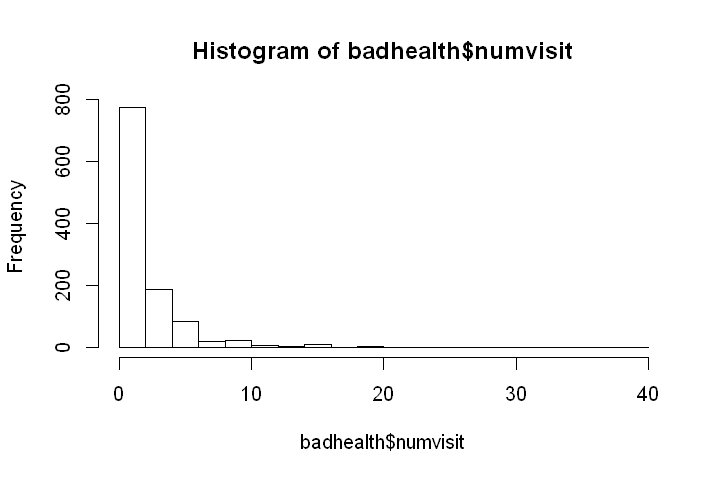

In [3]:
options(repr.plot.width = 6, repr.plot.height=4)

hist(badhealth$numvisit, breaks = 20)

In [4]:
library("ggplot2")

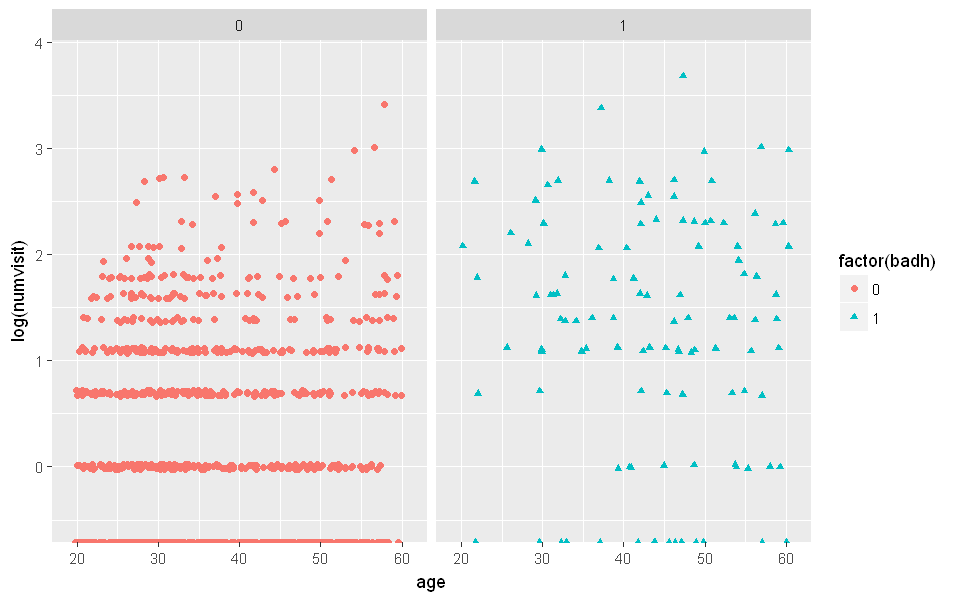

In [5]:
options(repr.plot.width = 8, repr.plot.height=5)

ggplot(badhealth, aes(x=age, y=log(numvisit), group=badh)) +
    geom_jitter(aes(shape=factor(badh), color=factor(badh))) +
            xlim(c(19,61))+
                ylim(c(-0.5,3.8)) +
                    facet_grid(.~factor(badh))

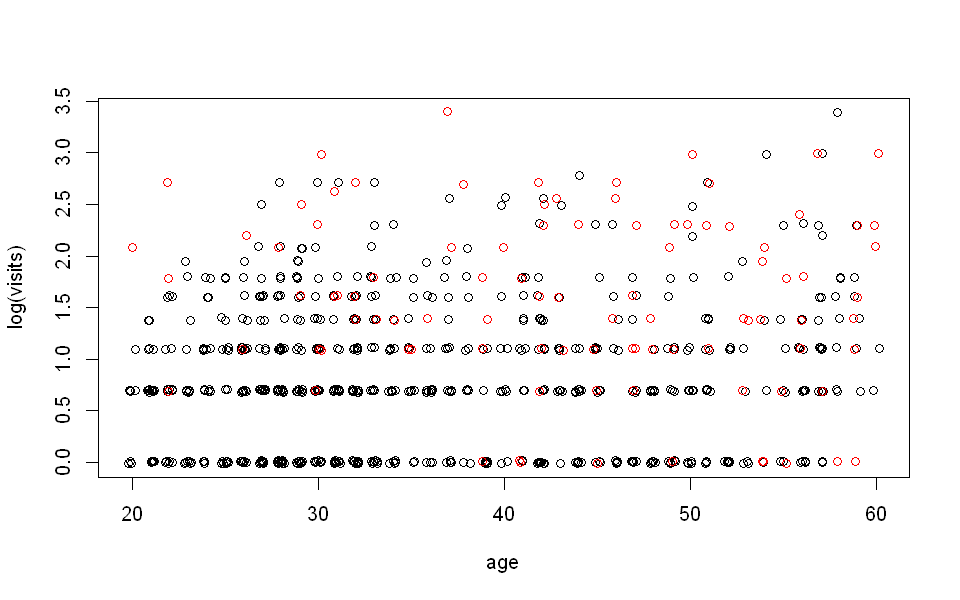

In [6]:
plot(jitter(log(numvisit)) ~ jitter(age), data=badhealth, subset=badh==0, xlab="age", ylab="log(visits)")
points(jitter(log(numvisit)) ~ jitter(age), data=badhealth, subset=badh==1, col="red")

# Model I

It appears that both age and bad health are related to the number of doctor visits. We should include model terms for both variables. If we believe the age/visits relationship is different between healthy and non-healthy populations, we should also include an interaction term.

In [7]:
library("coda")
library("rjags")

Warning message:
"package 'coda' was built under R version 3.4.4"Warning message:
"package 'rjags' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [8]:
model_str = " model {
    # Likelihood
    for(i in 1:length(numvisit)){
        numvisit[i] ~ dpois(lam[i])
        log(lam[i]) = int + b_badh*badh[i] + b_age*age[i] + b_intx*age[i]*badh[i]
    }

    # Priors
    int ~ dnorm(0.0, 1.0/1.0e6)
    b_badh ~ dnorm(0.0, 1.0/1.0e6)
    b_age ~ dnorm(0.0, 1.0/1.0e6)
    b_intx ~ dnorm(0.0, 1.0/1.0e6)
} "

In [9]:
set.seed(102)

In [10]:
# Data to be fed in model.

data_jags = as.list(badhealth)

In [11]:
# Parameter to be estimated

param_jags = c("int", "b_badh", "b_age", "b_intx")

In [12]:
mod = jags.model(textConnection(model_str), 
                 data = data_jags, 
                 n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1127
   Unobserved stochastic nodes: 4
   Total graph size: 3663

Initializing model



In [13]:
# Burnout and Monte Carlo 

update(mod, 1e3)

mod_sim = coda.samples(model = mod, 
                       variable.names = param_jags, 
                       n.iter = 1e4)

mod_csim = as.mcmc(do.call(rbind, mod_sim))

# Convergence Dignostics

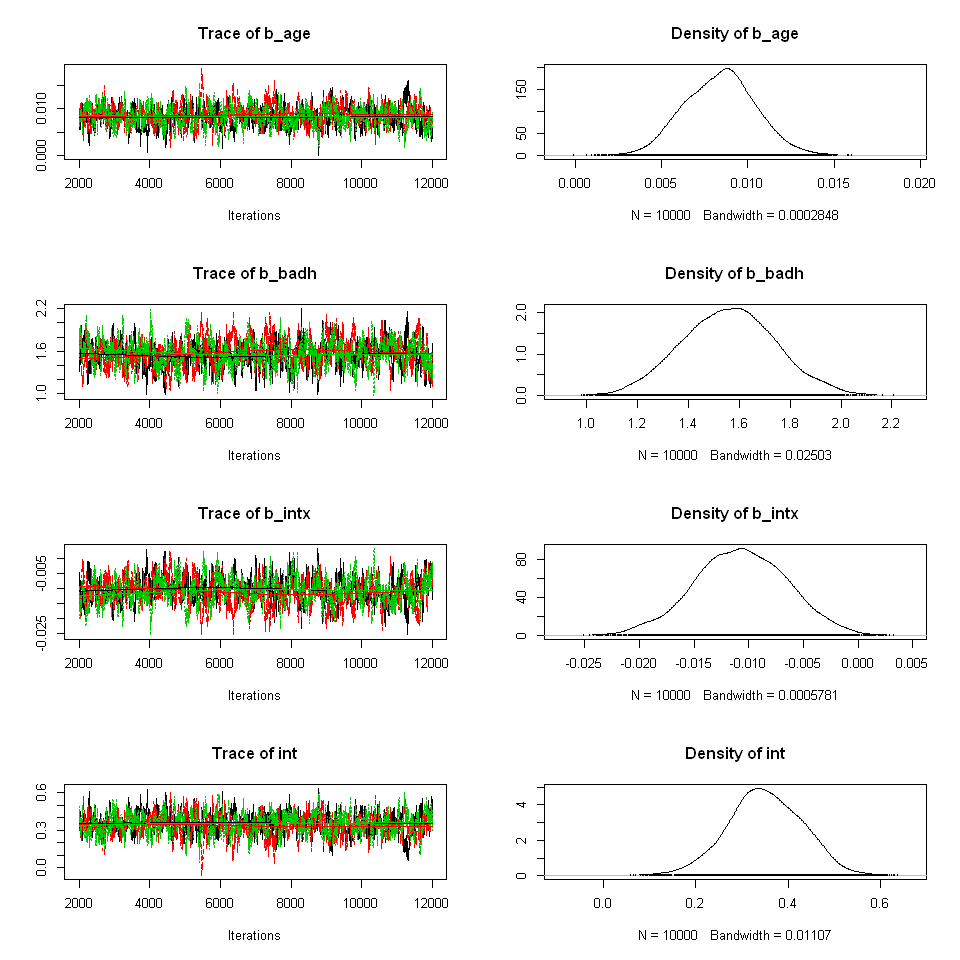

In [14]:
options(repr.plot.width = 8, repr.plot.height=8)

plot(mod_sim)

In [15]:
gelman.diag(mod_sim)
autocorr.diag(mod_sim)
effectiveSize(mod_sim)

Potential scale reduction factors:

       Point est. Upper C.I.
b_age        1.03       1.10
b_badh       1.03       1.11
b_intx       1.03       1.11
int          1.03       1.10

Multivariate psrf

1.04

,b_age,b_badh,b_intx,int
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000
Lag 1,0.9588052,0.9664718,0.9689855,0.9561875
Lag 5,0.8462190,0.8704654,0.8782319,0.8431575
Lag 10,0.7267649,0.7674191,0.7810981,0.7240788
Lag 50,0.1973079,0.2670158,0.2802247,0.1941465


b_age   b_badh   b_intx      int 
472.5045 393.5732 370.5909 477.6800

In [16]:
raftery.diag(mod_sim)

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                               
        Burn-in  Total  Lower bound  Dependence
        (M)      (N)    (Nmin)       factor (I)
 b_age  45       49134  3746         13.1      
 b_badh 45       46707  3746         12.5      
 b_intx 60       67896  3746         18.1      
 int    110      111875 3746         29.9      


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                              
        Burn-in  Total Lower bound  Dependence
        (M)      (N)   (Nmin)       factor (I)
 b_age  40       41604 3746         11.1      
 b_badh 48       48720 3746         13.0      
 b_intx 54       58386 3746         15.6      
 int    72       73440 3746         19.6      


[[3]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                              
        Burn-in  Total Lower bound  Dependence
      

In [17]:
dic.samples(model = mod, n.iter=1e4)

Mean deviance:  5630 
penalty 4.121 
Penalized deviance: 5634 

# Model Checking

In [18]:
X = as.matrix(badhealth[,-1])
X = cbind(X, with(badhealth, badh*age))
head(X)

badh,age,
0,58,0
0,54,0
0,44,0
0,57,0
0,33,0
0,28,0


In [19]:
# Median is less suceptible to noise as compared to the mean so I'm using median here instead of mean.

pmed_coef = apply(mod_csim, 2, median)
pmed_coef

b_age       b_badh       b_intx          int 
 0.008453837  1.560344535 -0.010715488  0.348963207

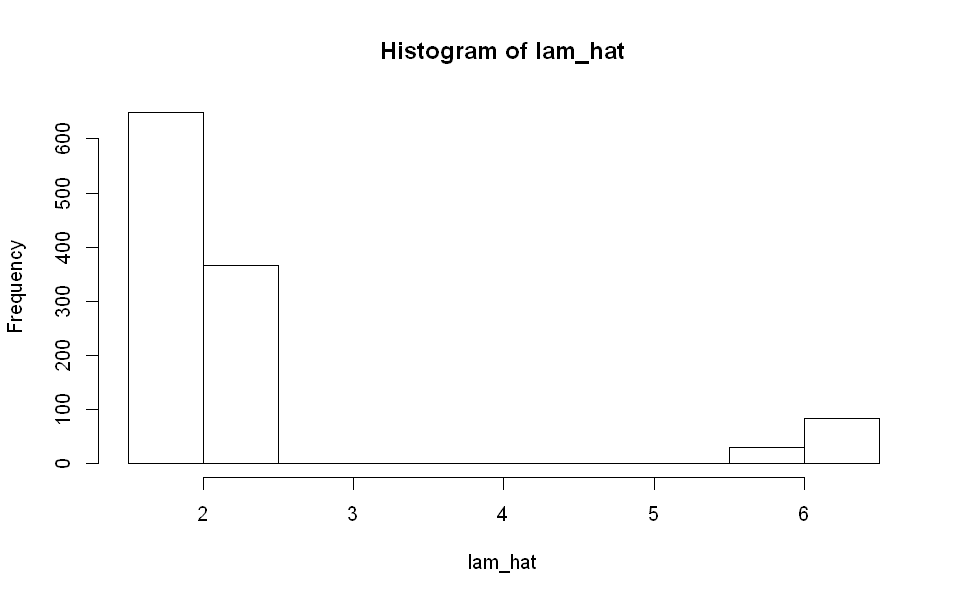

In [20]:
options(repr.plot.width=8, repr.plot.height=5)

llam_hat = pmed_coef["int"] + X %*% pmed_coef[c("b_badh", "b_age", "b_intx")]
lam_hat = exp(llam_hat) # Inverse link Function

hist(lam_hat)

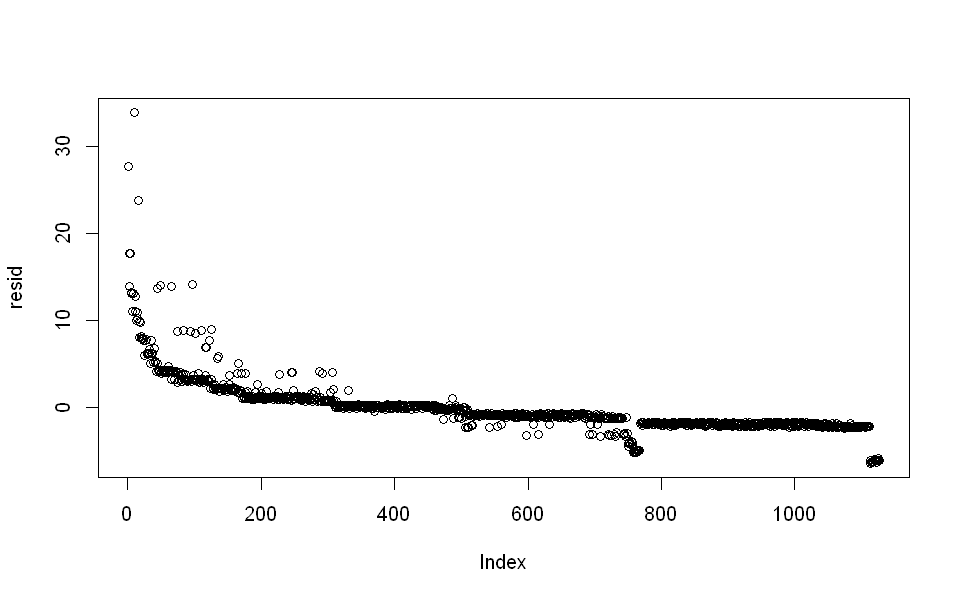

In [21]:
resid = badhealth$numvisit - lam_hat
plot(resid)

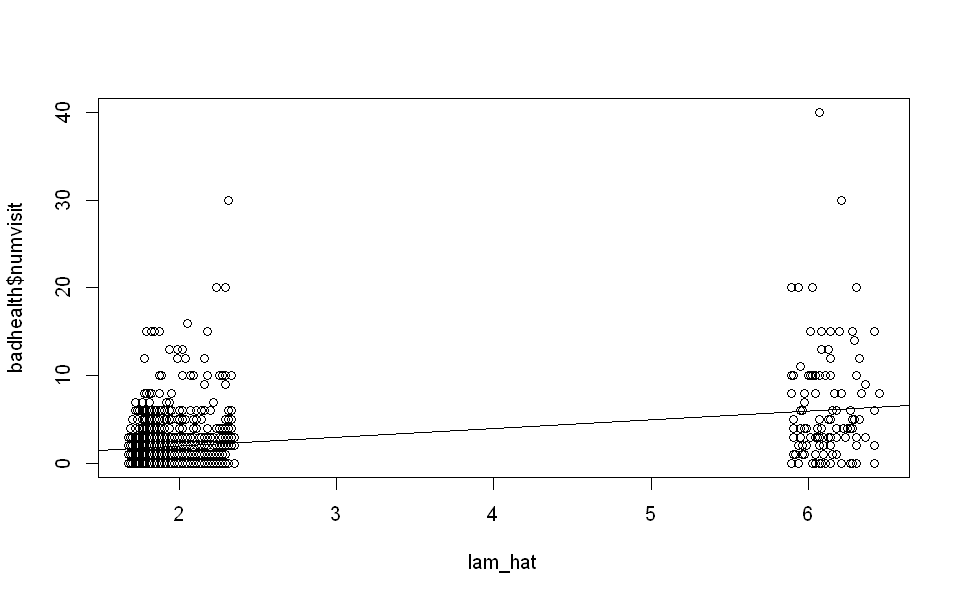

In [22]:
plot(lam_hat, badhealth$numvisit)
abline(0.0, 1.0)

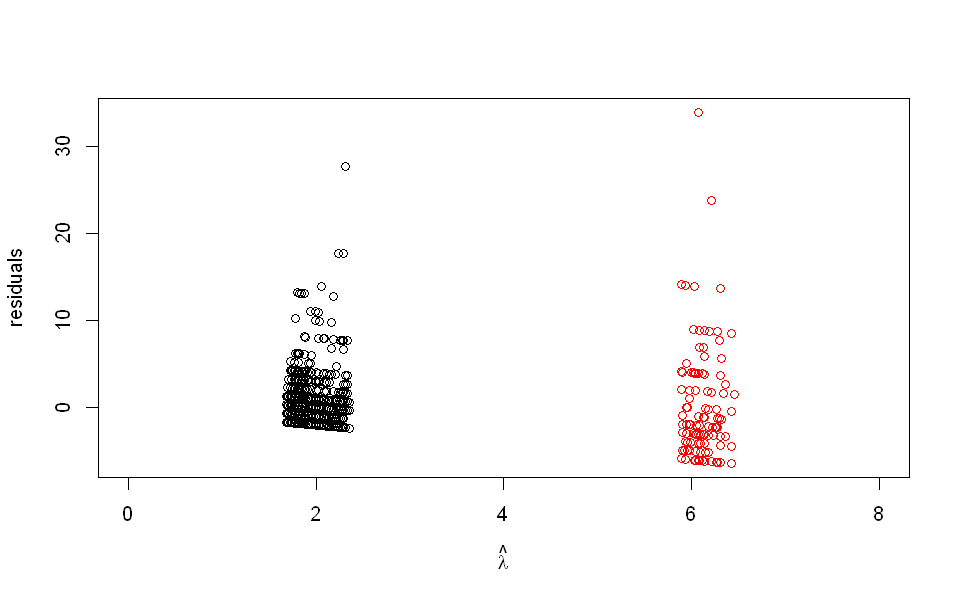

In [23]:
plot(lam_hat[which(badhealth$badh==0)], 
     resid[which(badhealth$badh==0)], 
     xlim=c(0, 8), ylab="residuals", 
     xlab=expression(hat(lambda)), 
     ylim=range(resid))

points(lam_hat[which(badhealth$badh==1)], 
       resid[which(badhealth$badh==1)], 
       col="red")

# It is not surprising that the variability increases for values predicted at higher values since the mean 
# is also the variance in the Poisson distribution. However, observations predicted to have about two visits 
# should have variance about two, and observations predicted to have about six visits should have variance about six.

In [24]:
var(resid[which(badhealth$badh==0)])

[1] 7.02255

In [25]:
var(resid[which(badhealth$badh==1)])

[1] 41.19623

Clearly this is not the case with these data. This indicates that either the model fits poorly (meaning the covariates don’t explain enough of the variability in the data), or the data are “overdispersed” for the Poisson likelihood we have chosen. This is a common issue with count data. If the data are more variable than the Poisson likelihood would suggest, a good alternative is the negative binomial distribution, which I will use sometime later, not now.

# Results

In [26]:
summary(mod_sim)


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean       SD  Naive SE Time-series SE
b_age   0.008406 0.002112 1.219e-05      9.756e-05
b_badh  1.559770 0.185632 1.072e-03      9.358e-03
b_intx -0.010713 0.004287 2.475e-05      2.224e-04
int     0.349971 0.082402 4.757e-04      3.784e-03

2. Quantiles for each variable:

            2.5%       25%       50%       75%     97.5%
b_age   0.004408  0.006944  0.008454  0.009779  0.012623
b_badh  1.198887  1.431984  1.560345  1.684982  1.932174
b_intx -0.019406 -0.013592 -0.010715 -0.007746 -0.002425
int     0.185018  0.296778  0.348963  0.406746  0.505532


The intercept is not necessarily interpretable here because it corresponds to a healthy 0-year-old, whereas the youngest person in the data set is 20 years old.

For healthy individuals, it appears that age has a positive association with number of doctor visits. Clearly, bad health is associated with an increase in expected number of visits. The interaction coefficient is interpreted as an adjustment to the age coefficient for people in bad health. Hence, for people with bad health, age is essentially unassociated with number of visits.

# Predictive distributions

Let’s say we have two people aged 35, one in good health and the other in poor health. What is the posterior probability that the individual with poor health will have more doctor visits? This goes beyond the posterior probabilities we have calculated comparing expected responses in previous lessons. Here we will create Monte Carlo samples for the responses themselves. This is done by taking the Monte Carlo samples of the model parameters, and for each of those, drawing a sample from the likelihood. Let’s walk through this.

In [27]:
# X values for two patients

x1 = c(0, 35, 0)
x2 = c(1, 35, 35)

In [28]:
# The posterior samples of the model parameters are stored in mod_csim:

head(mod_csim)

Markov Chain Monte Carlo (MCMC) output:
Start = 1 
End = 7 
Thinning interval = 1 
           b_age   b_badh      b_intx       int
[1,] 0.009668893 1.632108 -0.01239880 0.3298791
[2,] 0.008406972 1.610880 -0.01199242 0.3296632
[3,] 0.007566693 1.633036 -0.01244043 0.3625335
[4,] 0.007591196 1.634892 -0.01173070 0.3739922
[5,] 0.007339720 1.586402 -0.01017108 0.3927093
[6,] 0.007168649 1.554983 -0.01008407 0.3968422
[7,] 0.006985051 1.551824 -0.00982312 0.4047512

In [29]:
# First, we’ll compute the linear part of the predictor:

log_lam1 = mod_csim[,"int"] + mod_csim[,c("b_badh", "b_age", "b_intx")] %*% x1
log_lam2 = mod_csim[,"int"] + mod_csim[,c("b_badh", "b_age", "b_intx")] %*% x2

In [30]:
# Now we apply the inverse link.

lam1 = exp(log_lam1)
lam2 = exp(log_lam2)

The final step is to use these samples for the \(\lambda\) parameter for each individual and simulate actual number of doctor visits using the likelihood:

In [31]:
n_sim = length(lam1)
n_sim

[1] 30000

In [32]:
# Draw random samples from a poisson distribution using sampled lambda as parameters.

y1 = rpois(n=n_sim, lambda = lam1)
y2 = rpois(n=n_sim, lambda = lam2)

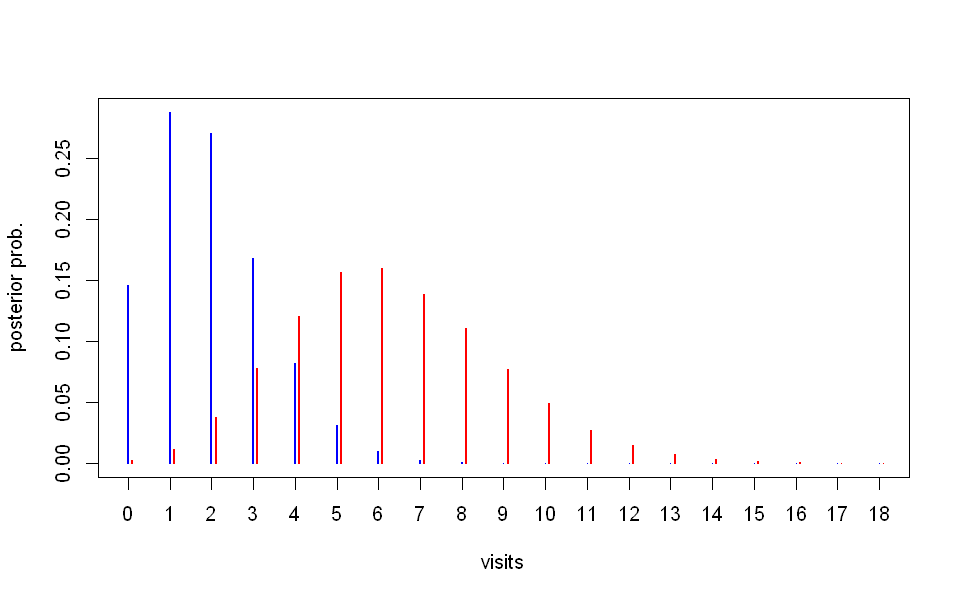

In [33]:
plot(table(factor(y1, levels=0:18))/n_sim, 
     pch=2, 
     ylab="posterior prob.", 
     xlab="visits",
     col="blue")

points(table(y2+0.1)/n_sim, 
       col="red")

# Blue <--------- Good Health
# Red <--------- Poor Health

In [34]:
# Finally, we can answer the original question: What is the probability that the person with poor health will 
# have more doctor visits than the person with good health?

In [35]:
mean(y2 > y1)

[1] 0.9195333

Because we used our posterior samples for the model parameters in our simulation, this posterior predictive distribution on the number of visits for these two new individuals naturally takes into account our uncertainty in the model estimates. This is a more honest/realistic distribution than we would get if we had fixed the model parameters at their MLE or posterior means and simulated data for the new individuals.

# Model II (without Interaction term)

In [36]:
model_str2 = " model {
    # Likelihood
    for(i in 1:length(numvisit)){
        numvisit[i] ~ dpois(lam[i])
        log(lam[i]) = int + b_badh*badh[i] + b_age*age[i]
    }

    # Priors
    int ~ dnorm(0.0, 1.0/1.0e6)
    b_badh ~ dnorm(0.0, 1.0/1.0e6)
    b_age ~ dnorm(0.0, 1.0/1.0e6)
} "

In [37]:
mod2 = jags.model(textConnection(model_str2), 
                 data = data_jags, 
                 n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1127
   Unobserved stochastic nodes: 3
   Total graph size: 3585

Initializing model



In [38]:
# Parameter to be estimated

param_jags2 = c("int", "b_badh", "b_age")

In [39]:
# Burnout and Monte Carlo 

update(mod2, 1e3)

mod_sim2 = coda.samples(model = mod2, 
                       variable.names = param_jags2, 
                       n.iter = 1e4)

mod_csim2 = as.mcmc(do.call(rbind, mod_sim2))

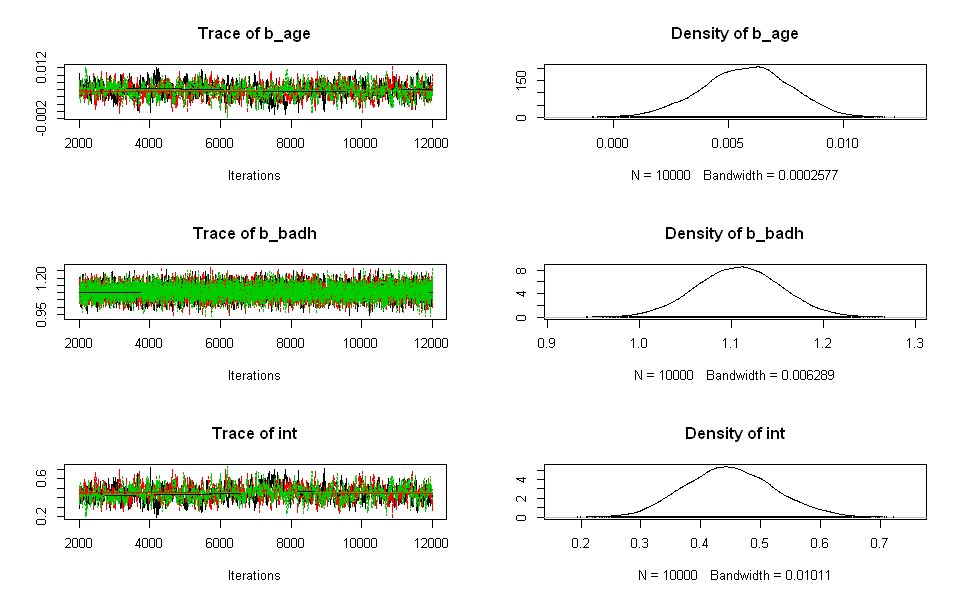

In [40]:
plot(mod_sim2)

In [41]:
gelman.diag(mod_sim2)
autocorr.diag(mod_sim2)
effectiveSize(mod_sim2)

Potential scale reduction factors:

       Point est. Upper C.I.
b_age           1          1
b_badh          1          1
int             1          1

Multivariate psrf

1

,b_age,b_badh,int
Lag 0,1.00000000,1.00000000,1.00000000
Lag 1,0.95197477,0.47387983,0.94737643
Lag 5,0.80149723,0.06115685,0.79499438
Lag 10,0.64411078,0.03394134,0.63577401
Lag 50,0.07208369,-0.01471446,0.07323569


b_age    b_badh       int 
 664.7410 8466.7858  684.6023

In [42]:
raftery.diag(mod_sim2)

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                              
        Burn-in  Total Lower bound  Dependence
        (M)      (N)   (Nmin)       factor (I)
 b_age  48       57588 3746         15.40     
 b_badh 6        6695  3746          1.79     
 int    24       24429 3746          6.52     


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                              
        Burn-in  Total Lower bound  Dependence
        (M)      (N)   (Nmin)       factor (I)
 b_age  36       37812 3746         10.10     
 b_badh 6        7195  3746          1.92     
 int    32       35016 3746          9.35     


[[3]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                              
        Burn-in  Total Lower bound  Dependence
        (M)      (N)   (Nmin)       factor (I)
 b_age  35       36250 3746          9.68     
 b_badh 6    

In [43]:
dic.samples(mod2, n.iter = 1e4)

Mean deviance:  5636 
penalty 2.972 
Penalized deviance: 5639 

# Another Example

In [44]:
dat = read.csv(file="callers.csv", header=TRUE)

In [72]:
head(dat)

calls,days_active,isgroup2,age
2,32,0,27
4,81,0,32
0,41,0,22
1,36,0,28
0,55,0,31
0,25,0,33


In [45]:
summary(lm(calls ~ days_active + isgroup2 + age, data=as.data.frame(scale(dat))))


Call:
lm(formula = calls ~ days_active + isgroup2 + age, data = as.data.frame(scale(dat)))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9579 -0.4581 -0.1373  0.3614  3.1971 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.205e-16  5.102e-02   0.000        1    
days_active  3.640e-01  5.120e-02   7.109 1.61e-11 ***
isgroup2     5.212e-01  5.128e-02  10.164  < 2e-16 ***
age         -2.127e-01  5.127e-02  -4.148 4.78e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7636 on 220 degrees of freedom
Multiple R-squared:  0.4248,	Adjusted R-squared:  0.417 
F-statistic: 54.16 on 3 and 220 DF,  p-value: < 2.2e-16


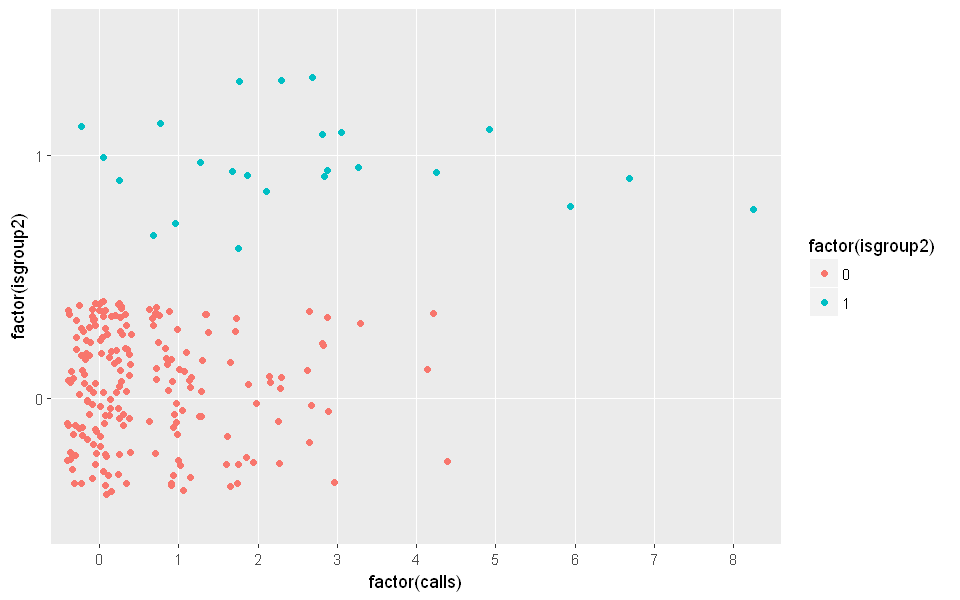

In [46]:
ggplot(dat) + 
    geom_jitter(aes(x=factor(calls), y=factor(isgroup2), col = factor(isgroup2)))

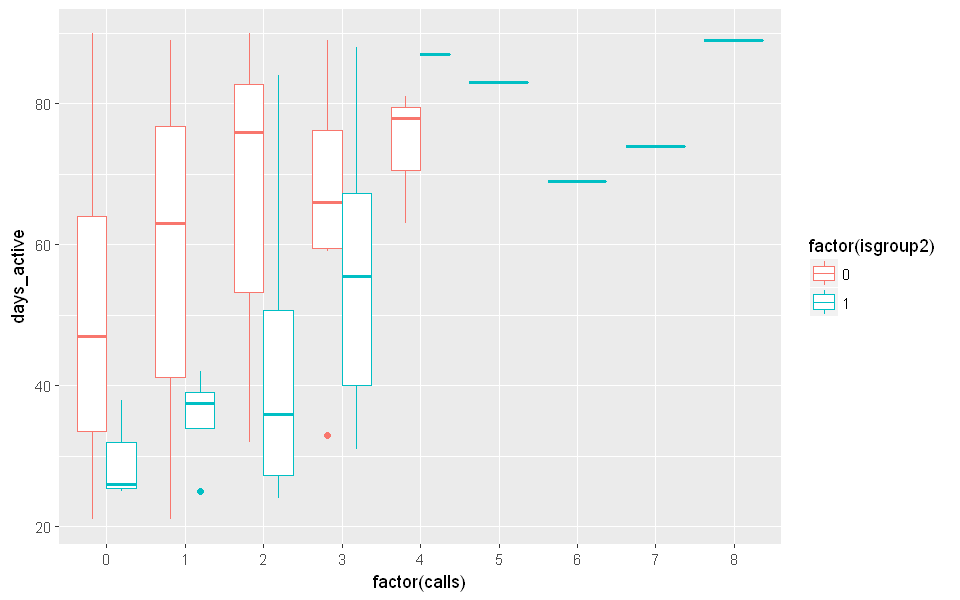

In [47]:
ggplot(dat) + 
    geom_boxplot(aes(x=factor(calls), y=days_active, col = factor(isgroup2)))

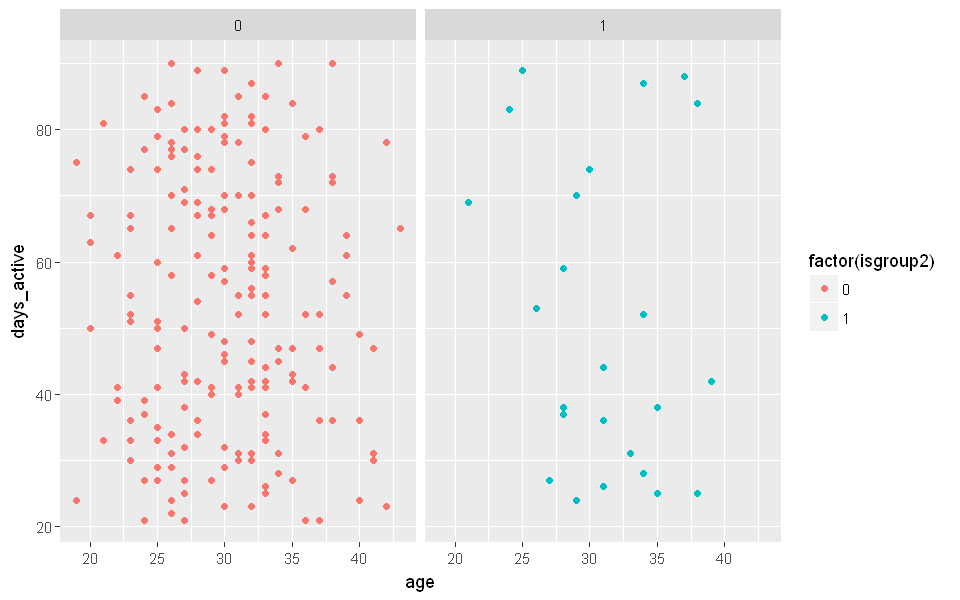

In [48]:
ggplot(dat) + 
    geom_point(aes(x=age, y=days_active, col = factor(isgroup2))) +
        facet_grid(. ~ factor(isgroup2))

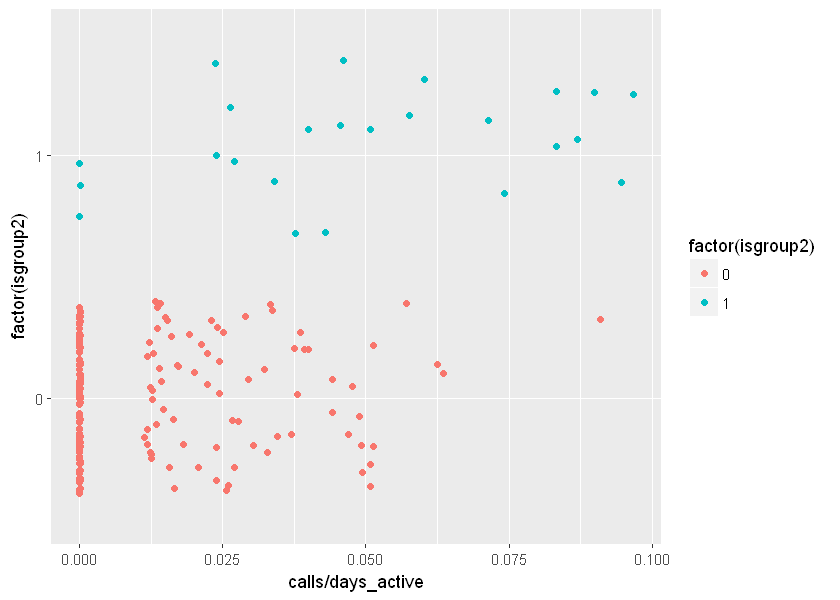

In [159]:
ggplot(dat) + 
    geom_jitter(aes(x=calls/days_active, y = factor(isgroup2), col = factor(isgroup2)))

In [58]:
mod_str = " model {
    # Likelihood
    for (i in 1:length(calls)) {
        calls[i] ~ dpois( days_active[i] * lam[i] )
        log(lam[i]) = b[1] + b[2]*age[i] + b[3]*isgroup2[i]
    }

    # Priors
    for(j in 1:3){
        b[j] ~ dnorm(0, 1/1e4)
    }
} "

In [59]:
colnames(scale(dat))

[1] "calls"       "days_active" "isgroup2"    "age"

In [60]:
dat_jags = as.list(dat)

In [61]:
para_jags = c("b")

In [62]:
mod_p = jags.model(textConnection(mod_str), 
                   data = dat_jags, 
                   n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 224
   Unobserved stochastic nodes: 3
   Total graph size: 1218

Initializing model



In [63]:
update(mod_p, 5e3)

In [64]:
mod_p_sim = coda.samples(model = mod_p, 
                         variable.names = para_jags, 
                         n.iter = 5e4)

In [65]:
mod_p_csim = as.mcmc(do.call(rbind, mod_p_sim))

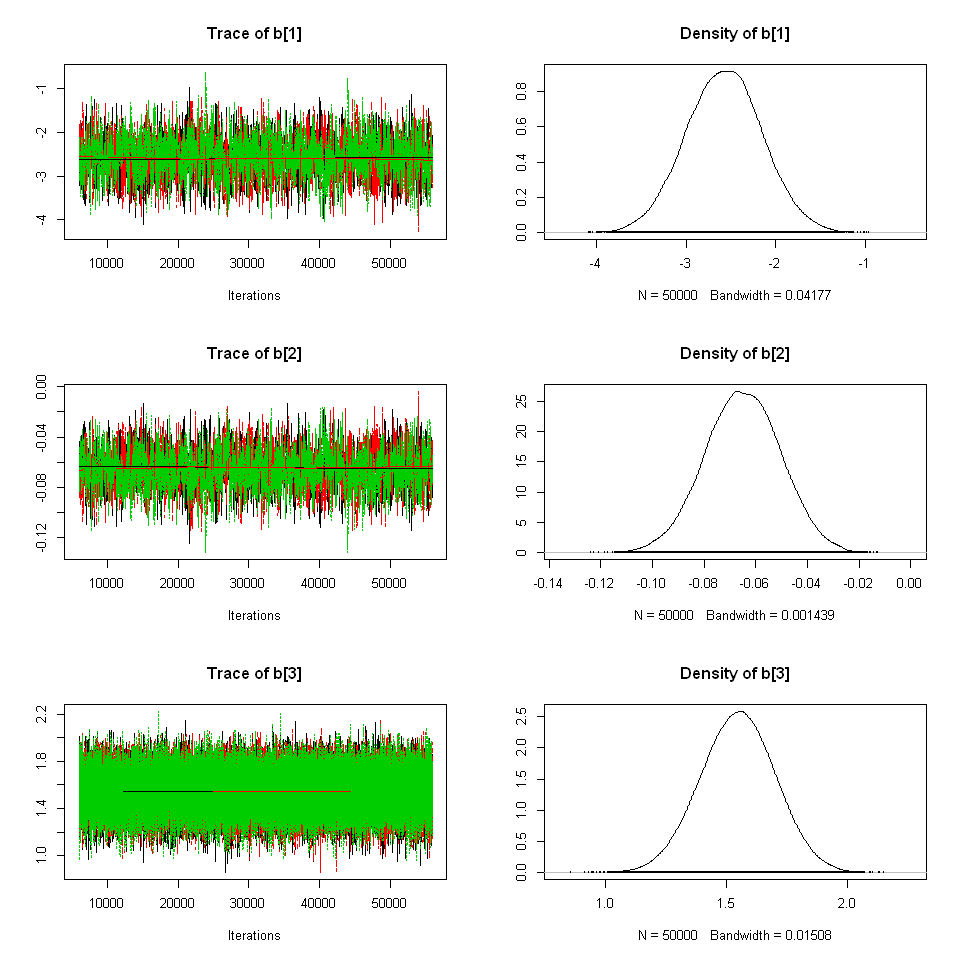

In [66]:
options(prepr.plot.width=8, repr.plot.height=8)

plot(mod_p_sim)

In [67]:
gelman.diag(mod_p_sim)
autocorr.diag(mod_p_sim)
effectiveSize(mod_p_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.01       1.02
b[2]       1.01       1.02
b[3]       1.00       1.00

Multivariate psrf

1

,b[1],b[2],b[3]
Lag 0,1.0000000,1.0000000,1.0000000000
Lag 1,0.9775242,0.9771840,0.4963241900
Lag 5,0.9050174,0.9043572,0.0300611581
Lag 10,0.8239586,0.8235889,-0.0009636798
Lag 50,0.3954391,0.3955621,-0.0059150875


b[1]      b[2]      b[3] 
 1443.655  1439.163 50386.496

In [68]:
raftery.diag(mod_p_sim)

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 112      112770 3746         30.10     
 b[2] 110      112860 3746         30.10     
 b[3] 8        9184   3746          2.45     


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 96       104244 3746         27.8      
 b[2] 91       105768 3746         28.2      
 b[3] 6        6731   3746          1.8      


[[3]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
      Burn-in  Total  Lower bound  Dependence
      (M)      (N)    (Nmin)       factor (I)
 b[1] 75       79890  3746         21.30     
 b[2] 120      130296 3746   

In [71]:
coeffs = colMeans(mod_p_csim)
coeffs

# b[1] <--------- It represents intercept.
# b[2] <--------- It represents coefficient of age.
# b[3] <--------- It represents coefficient of isgroup2.

b[1]        b[2]        b[3] 
-2.57287315 -0.06503616  1.54816011

In [91]:
colnames(dat)

[1] "calls"       "days_active" "isgroup2"    "age"

In [113]:
idx0 = dat[,"isgroup2"] == 0
idx1 = dat[,"isgroup2"] == 1

In [114]:
lam_hat1 = coeffs[1] + dat[idx0, c("age")]*coeffs[2] + dat[idx0, c("isgroup2")]*coeffs[3]
lam_hat2 = coeffs[1] + dat[idx1, c("age")]*coeffs[2] + dat[idx1, c("isgroup2")]*coeffs[3]

lam1 = exp(lam_hat1)
lam2 = exp(lam_hat2)

In [115]:
n_sim = length(mod_p_csim)

In [116]:
y1 = rpois(n=n_sim, 
           lambda = lam1 * dat[idx0, c("days_active")])

y2 = rpois(n=n_sim, 
           lambda = lam2 * dat[idx1, c("days_active")])

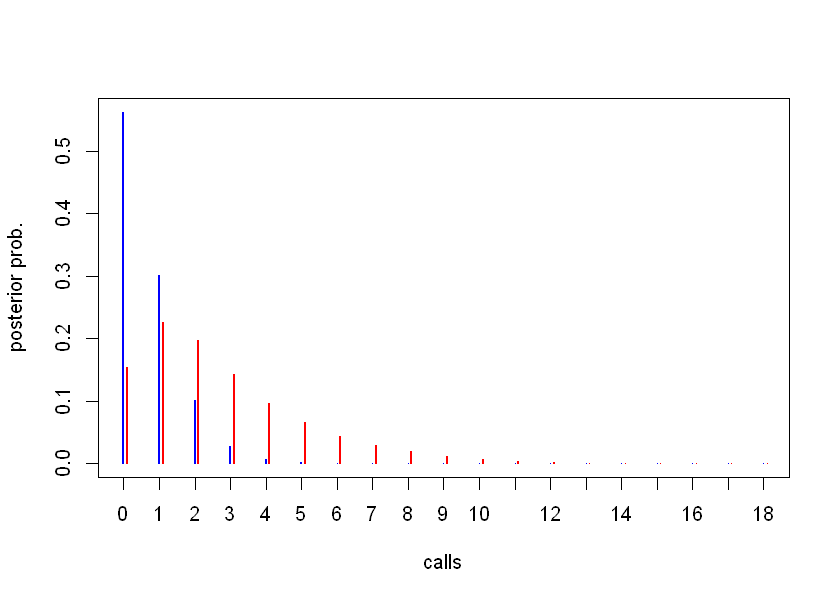

In [124]:
options(repr.plot.width = 7, repr.plot.height = 5)

plot(table(factor(y1, levels=0:18))/n_sim, 
     ylab="posterior prob.", 
     xlab="calls",
     col="blue")

points(table(y2+0.1)/n_sim, 
       col="red")

# Blue <--------- Not Group2
# Red <--------- Group2

In [125]:
mean(y2 > y1)

[1] 0.7133578

In [105]:
# Probability that coefficient of isgroup2 is greator than 0

mean(mod_p_csim[,3] > 0)

[1] 1

<h1><center> Prior sensitivity analysis </center></h1>

When communicating results from any analysis, a responsible statistician will report and justify modeling decisions, especially assumptions. In a Bayesian analysis, there is another assumption that is open to scrutiny: the choices of prior distributions. In the models considered so far in this course, there are an infinite number of prior distributions we could have chosen from.

How do you justify the priors you choose? If they truly represent your beliefs about the parameters before analysis and the model is appropriate, then the posterior distribution truly represents your updated beliefs. If you don’t have any strong beliefs beforehand, there are often default, reference, or noninformative prior options, and you will have to select one. However, a collaborator or a boss (indeed, somebody somewhere) may not agree with your choice of prior. One way to increase the credibility of your results is to repeat the analysis under a variety of priors, and report how the results differ as a result. This process is called prior sensitivity analyis.

At a minimum you should always report your choice of model and prior. If you include a sensitivity analysis, select one or more alternative priors and describe how the results of the analysis change. If they are sensitive to the choice of prior, you will likely have to explain both sets of results, or at least explain why you favor one prior over another. If the results are not sensitive to the choice of prior, this is evidence that the data are strongly driving the results. It suggests that different investigators coming from different backgrounds should come to the same conclusions.

If the purpose of your analysis is to establish a hypothesis, it is often prudent to include a "skeptical" prior which does not favor the hypothesis. Then, if the posterior distribution still favors the hypothesis despite the unfavorable prior, you will be able to say that the data substantially favor the hypothesis. This is the approach we will take in the following example, continued from the previous lesson.

# Poisson regression example

In [ ]:
# I Model

mod_string = " model {
    for (i in 1:length(numvisit)) {
        numvisit[i] ~ dpois(lam[i])
        log(lam[i]) = int + b_badh*badh[i] + b_age*age[i] + b_intx*age[i]*badh[i]
    }
    
    int ~ dnorm(0.0, 1.0/1e6)
    b_badh ~ dnorm(0.0, 1.0/1e4)
    b_age ~ dnorm(0.0, 1.0/1e4)
    b_intx ~ dnorm(0.0, 1.0/1e4)
} "

set.seed(102)

data_jags = as.list(badhealth)

params = c("int", "b_badh", "b_age", "b_intx")

mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3)
update(mod, 1e3)

mod_sim = coda.samples(model=mod,
                       variable.names=params,
                       n.iter=5e3)

mod_csim = as.mcmc(do.call(rbind, mod_sim))

In [ ]:
plot(density(mod_csim[,"b_badh"]))

# Essentially all of the posterior probability mass is above 0, suggesting that this coefficient is positive 
# (and consequently that bad health is associated with more visits). We obtained this result using a relatively 
# noninformative prior. What if we use a prior that strongly favors values near 0? Let’s repeat the analysis with 
# a normal prior on the badh coefficient that has mean 0 and standard deviation 0.2, so that the prior probability 
# that the coefficient is less than 0.6 is \(>0.998\). We’ll also use a small variance on the prior for the interaction
# term involving badh (standard deviation 0.01 because this coefficient is on a much smaller scale).

In [ ]:
# II Model

mod2_string = " model {
    for (i in 1:length(numvisit)) {
        numvisit[i] ~ dpois(lam[i])
        log(lam[i]) = int + b_badh*badh[i] + b_age*age[i] + b_intx*age[i]*badh[i]
    }
    
    int ~ dnorm(0.0, 1.0/1e6)
    b_badh ~ dnorm(0.0, 1.0/0.2^2)
    b_age ~ dnorm(0.0, 1.0/1e4)
    b_intx ~ dnorm(0.0, 1.0/0.01^2)
} "

mod2 = jags.model(textConnection(mod2_string), 
                  data=data_jags, 
                  n.chains=3)
update(mod2, 1e3)

mod2_sim = coda.samples(model=mod2,
                        variable.names=params,
                        n.iter=5e3)

mod2_csim = as.mcmc(do.call(rbind, mod2_sim))

In [ ]:
curve(dnorm(x, mean=0.0, sqrt(1e4)), 
      from = -3, to = 3,
      col="blue",
      ylim = c(0.0, 3.5),
      lty = 2,
      ylab = "density", 
      xlab = "b_badh")

curve(dnorm(x, mean=0.0, sd=0.2), 
      from=-3.0, to=3.5, 
      col="red", 
      lty=2, 
      add=TRUE)

lines(density(mod_csim[,"b_badh"]),
      col="blue")

lines(density(mod2_csim[,"b_badh"]), 
      col="red")

legend("topleft", 
       legend=c("noninformative prior", "posterior", "skeptical prior", "posterior"),
       lty=c(2,1,2,1), 
       col=rep(c("blue", "red"), each=2),
       bty="n")

Under the skeptical prior, our posterior distribution for b_badh has significantly dropped to between about 0.6 and 1.1. Although the strong prior influenced our inference on the magnitude of the bad health effect on visits, it did not change the fact that the coefficient is significantly above 0. In other words: even under the skeptical prior, bad health is associated with more visits, with posterior probability near 1.

In [ ]:
# We should also check the effect of our skeptical prior on the interaction term involving both age and health.

curve(dnorm(x, mean=0.0, sd=sqrt(1e4)), 
      from=-0.05, 
      to=0.05, 
      col="blue",
      ylim=c(0.0, 140.0), 
      lty=2,
      main="b_intx", 
      ylab="density", 
      xlab="b_intx")

curve(dnorm(x, mean=0.0, sd=0.01), 
      from=-0.05, 
      to=0.05, 
      col="red", 
      lty=2, 
      add=TRUE)

lines(density(mod_csim[,"b_intx"]), 
      col="blue")

lines(density(mod2_csim[,"b_intx"]), 
      col="red")

legend("topleft", 
       legend=c("noninformative prior", "posterior", "skeptical prior", "posterior"),
       lty=c(2,1,2,1), 
       col=rep(c("blue", "red"), each=2), 
       bty="n")

In [ ]:
mean(mod2_csim[,"b_intx"] > 0)

The result here is interesting. Our estimate for the interaction coefficient has gone from negative under the noninformative prior to positive under the skeptical prior, so the result is sensitive. In this case, because the skeptical prior shrinks away much of the bad health main effect, it is likely that this interaction effect attempts to restore some of the positive effect of bad health on visits. Thus, despite some observed prior sensitivity, our conclusion that bad health positively associates with more visits remains unchanged.